# Template: simulating compendia by latent transformation

This template notebook simulates gene expression data by encoding experiments into the latent space and then shifting samples from that experiment in the latent space. Unlike the "Simulation by random sampling" approach, this method accounts for experiment level information by shifting samples from the same experiment together. This notebook uses `simulate_by_latent_transform`, described [here](ponyo/simulate_expression_data.py), which inputs a dataset with multiple experiments (these are your template experiments) and then it outputs the same number of new simulated experiments that are created by shifting a randomly sampled template experiment. This simulation generates a collection of different types of experiments.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import umap
import glob
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
train_vae_modules.set_all_seeds()

In [3]:
# Read in config variables
config_filename = "config_simulate_by_latent_transform.tsv"
params = utils.read_config(config_filename)

In [4]:
# Load parameters
local_dir = params["local_dir"]
raw_compendium_filename = params["raw_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
latent_dim = params["latent_dim"]
vae_model_dir = params["vae_model_dir"]
training_stats_dir = params["training_stats_dir"]
metadata_filename = params["metadata_filename"]
metadata_delimiter = params["metadata_delimiter"]
metadata_experiment_colname = params['metadata_experiment_colname']
metadata_sample_colname = params['metadata_sample_colname']
experiment_ids_filename = params["experiment_ids_filename"]
num_simulated = params['num_simulated']

In [5]:
assert os.path.exists(raw_compendium_filename)

## Setup directories

In [6]:
utils.setup_dir(config_filename)

## Pre-process data

In [7]:
train_vae_modules.normalize_expression_data(config_filename,
                                            raw_compendium_filename,
                                            normalized_compendium_filename)

input: dataset contains 273 samples and 5000 genes
Output: normalized dataset contains 273 samples and 5000 genes


In [8]:
utils.create_experiment_id_file(metadata_filename,
                                normalized_compendium_filename,
                                experiment_ids_filename,
                                config_filename)

There are 3220 experiments in the compendium
There are 9 experiments with gene expression data
9 experiment ids saved to file


## Train VAE

input dataset contains 273 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 246 samples, validate on 27 samples
Epoch 1/10
246/246 [==============================] - 21s 86ms/step - loss: 2340.0547 - kl_loss: 13.9695 - recons_loss: 2340.0549 - val_loss: 2576.0480 - val_kl_loss: 138.0642 - val_recons_loss: 2576.0481
Epoch 2/10
246/246 [==============================] - 21s 84ms/step - loss: 2167.1977 - kl_loss: 13.5955 - recons_loss: 2167.1978 - val_loss: 2336.0937 - val_kl_loss: 78.0098 - val_recons_loss: 2336.0938
Epoch 3/10
246/246 [==============================] - 21s 87ms/step - loss: 2154.3709 - kl_loss: 13.6479 - recons_loss: 2154.3708 - val_loss: 2209.3619 - val_kl_loss: 48.0506 - val_recons_loss: 2209.3618
Epoch 4/10
246/246 [==============================] 

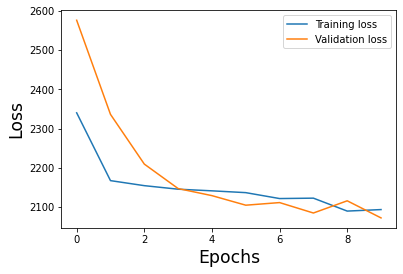

In [9]:
# Train VAE
train_vae_modules.train_vae(config_filename,
                            normalized_compendium_filename)

## Simulate data by latent transformation

In [10]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_latent_transformation(
    num_simulated,
    normalized_compendium_filename,
    vae_model_dir,
    latent_dim,
    metadata_filename,
    metadata_delimiter,
    metadata_experiment_colname,
    metadata_sample_colname,
    experiment_ids_filename,
    local_dir,
)

Normalized gene expression data contains 273 samples and 5000 genes
Return: simulated gene expression data containing 1766 samples and 5001 genes


## Visualize latent transform compendium

In [11]:
# Load VAE models
model_encoder_filename = glob.glob(os.path.join(
        vae_model_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

In [12]:
pca = PCA(n_components=2)

In [13]:
# Read data
normalized_compendium = pd.read_csv(normalized_compendium_filename, header=0, sep="\t", index_col=0)

In [14]:
# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=normalized_compendium.index)

# Get and save PCA model
model = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['experiment_id'] = 'background compendium'

In [15]:
# Embedding of real template experiment (encoded)
before_encoded_filename = os.path.join(local_dir, "simulated_before_encoded.tsv")

template_encoded_df = pd.read_csv(before_encoded_filename, header=0, sep='\t', index_col=0)

template_PCAencoded = model.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['experiment_id'] = 'template_experiment'

In [16]:
# Embedding of simulated experiment (encoded)
after_encoded_filename = os.path.join(local_dir, "simulated_after_encoded.tsv")

simulated_encoded_df = pd.read_csv(after_encoded_filename,header=0, sep='\t', index_col=0)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [17]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(291, 3)


,1,2,experiment_id
SRR493816,2.039330,-0.705364,background compendium
SRR493817,2.281067,-0.240048,background compendium
SRR547975,1.517259,-2.206534,background compendium
SRR547973,1.778050,-0.918977,background compendium
SRR547968,2.048751,-1.149199,background compendium


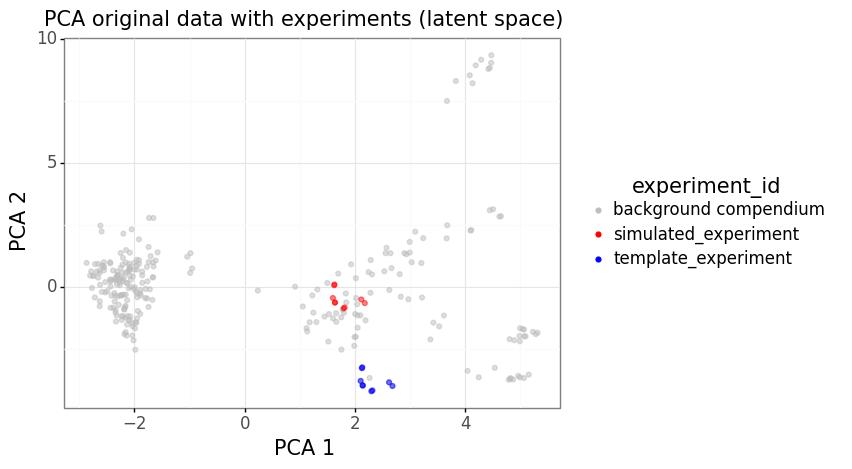

<ggplot: (8732417109353)>


In [18]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.5)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'after_experiment'],
                  alpha=0.2, 
                  color='red')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'before_experiment'],
                  alpha=0.2, 
                  color='blue')

print(fig)